# In-Database Image Classification using Xilinx FPGA


In [1]:
# Step 1: First import modules we use in this demo
import os,sys,cv2
from __future__ import print_function

from matplotlib import pyplot as plt
%matplotlib inline

In [3]:
# Connect to deepgreen
import dg.conn
from dg.admin import activity
con = dg.conn.Conn(user="mluser", port=5432)
print (con.ver)

5


In [4]:
# We have setup xdrive to ls image files.   Let's see the files, 
xt = dg.xtable.fromQuery(con, '''
select dir, basename from 
imagefiles where basename like '%jpeg' or basename like '%jpg'
''')

xt5 = xt.select(where="dir like '%cat%'", samplerows=5)
print(xt5.sql)
print(xt5.show())

WITH tmp_1 as (
select dir, basename from 
imagefiles where basename like '%jpeg' or basename like '%jpg'
)
select * from tmp_1 where dir like '%cat%' limit sample 5 rows
+-------------------------------------------------------------------------------+----------------+
| dir                                                                           | basename       |
|-------------------------------------------------------------------------------+----------------|
| /home/mluser/quicksetup/u16.alveo/xdrive/images/101_ObjectCategories/wild_cat | image_0002.jpg |
| /home/mluser/quicksetup/u16.alveo/xdrive/images/101_ObjectCategories/wild_cat | image_0025.jpg |
| /home/mluser/quicksetup/u16.alveo/xdrive/images/101_ObjectCategories/wild_cat | image_0023.jpg |
| /home/mluser/quicksetup/u16.alveo/xdrive/images/101_ObjectCategories/wild_cat | image_0015.jpg |
| /home/mluser/quicksetup/u16.alveo/xdrive/images/101_ObjectCategories/wild_cat | image_0001.jpg |
+------------------------------------

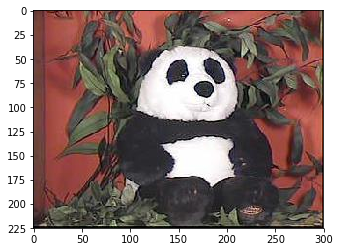

In [5]:
# Now, display a few images.
panda = cv2.imread("/home/mluser/quicksetup/u16.alveo/xdrive/images/101_ObjectCategories/panda/image_0026.jpg")
panda = cv2.cvtColor(panda, cv2.COLOR_BGR2RGB)
plt.imshow(panda)
plt.show()

In [6]:
# Run a image recognition
gnet = dg.xtable.fromQuery(con, '''
select substr(filename, 54) as filename, nth, score, substr(tag, 0, 40) as tag from (
select 
dg_utils.transducer_column_text(1) as filename,
dg_utils.transducer_column_int4(2) as nth, 
dg_utils.transducer_column_float4(3) as score,
dg_utils.transducer_column_text(4) as tag,
gnet(), t.*
from (
    select dir || '/' || basename from imagefiles where 
    (basename like '%jpeg' or basename like '%jpg')
    and dir like '%panda%'
) t
) tmpt
''')


print(gnet.show(tablefmt='fancy_grid'))


╒══════════════════════════════════════╤═══════╤═════════════╤═════════════════════════════════════════╕
│ filename                             │   nth │       score │ tag                                     │
╞══════════════════════════════════════╪═══════╪═════════════╪═════════════════════════════════════════╡
│ bjectCategories/panda/image_0004.jpg │     0 │ 0.217357    │ n02093256 Staffordshire bullterrier, St │
├──────────────────────────────────────┼───────┼─────────────┼─────────────────────────────────────────┤
│ bjectCategories/panda/image_0004.jpg │     1 │ 0.187895    │ n02096585 Boston bull, Boston terrier   │
├──────────────────────────────────────┼───────┼─────────────┼─────────────────────────────────────────┤
│ bjectCategories/panda/image_0004.jpg │     2 │ 0.0807991   │ n03803284 muzzle                        │
├──────────────────────────────────────┼───────┼─────────────┼─────────────────────────────────────────┤
│ bjectCategories/panda/image_0004.jpg │     3 │ 0.0604

In [7]:
q1 = gnet.select(select='filename, nth, score, tag', where = "nth > 0 and tag like 'n02510455%'")
print (q1.show())

+--------------------------------------+-------+------------+-----------------------------------------+
| filename                             |   nth |      score | tag                                     |
|--------------------------------------+-------+------------+-----------------------------------------|
| bjectCategories/panda/image_0004.jpg |     3 | 0.0604807  | n02510455 giant panda, panda, panda bea |
| bjectCategories/panda/image_0028.jpg |     1 | 0.00365611 | n02510455 giant panda, panda, panda bea |
| bjectCategories/panda/image_0020.jpg |     1 | 0.195016   | n02510455 giant panda, panda, panda bea |
| bjectCategories/panda/image_0027.jpg |     1 | 0.222496   | n02510455 giant panda, panda, panda bea |
+--------------------------------------+-------+------------+-----------------------------------------+


In [8]:
# Run a image recognition
gnet = dg.xtable.fromQuery(con, '''
select tag, count(*) as cnt from (
select 
dg_utils.transducer_column_text(1) as filename,
dg_utils.transducer_column_int4(2) as nth, 
dg_utils.transducer_column_float4(3) as score,
dg_utils.transducer_column_text(4) as tag,
gnet(), t.*
from (
    select dir || '/' || basename from imagefiles where 
    (basename like '%jpeg' or basename like '%jpg')
    and dir like '%panda%'
) t
) tmpt 
where nth = 0
group by tag
''')


print(gnet.show())

+-----------------------------------------------------------------------------+-------+
| tag                                                                         |   cnt |
|-----------------------------------------------------------------------------+-------|
| n04120489 running shoe                                                      |     1 |
| n04399382 teddy, teddy bear                                                 |     8 |
| n02093256 Staffordshire bullterrier, Staffordshire bull terrier             |     1 |
| n03929660 pick, plectrum, plectron                                          |     1 |
| n03534580 hoopskirt, crinoline                                              |     1 |
| n02105641 Old English sheepdog, bobtail                                     |     1 |
| n02510455 giant panda, panda, panda bear, coon bear, Ailuropoda melanoleuca |    18 |
| n01773549 barn spider, Araneus cavaticus                                    |     1 |
| n07836838 chocolate sauce, cho

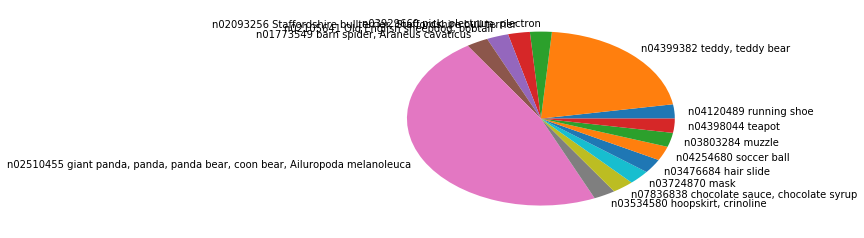

In [9]:
import dg.dsutil.plot
rows = gnet.execute()
pc = dg.dsutil.plot.PieChart(gnet.coldata('cnt', rows), labels=gnet.coldata('tag', rows))
pc.draw()